## This file is used to figure out if boundary tilting can happen even in a 3D example
## The current setting seems to generate boundary tilting: there are other useful features, but the neural network focuses on the non-robust one

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from torch.utils.data import Dataset, DataLoader , TensorDataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.cluster import SpectralClustering
import sklearn.datasets
from tqdm import tqdm, trange

from sklearn.metrics import accuracy_score
import plotly.graph_objects as go

seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [2]:
block = 9
num_points_each_tile = 100
dim = 100
num_non_robust_features = 1
non_robust_feature_width = 0.05
#non_robust_feature_width = 0
noise_sigma = 0.01
#noise_sigma = 0

In [3]:
x_original = np.zeros((block**2,2))
y_original = np.zeros(block**2)

tmp = np.arange(block)
x_original[:,0] = np.tile(tmp,block)
x_original[:,1] = np.repeat(tmp,block)
y_original[:] = np.mod(x_original[:,0] + x_original[:,1],2)

x = np.zeros((block**2*num_points_each_tile, 2))
x[:,0] = np.repeat(x_original[:,0],num_points_each_tile)
x[:,1] = np.repeat(x_original[:,1],num_points_each_tile)
y = np.repeat(y_original,num_points_each_tile)
y = y.astype(int)

num_points_each_edge = num_points_each_tile//4

noise = np.zeros((0,2))

margin = 0.3
width = 0.2

for _ in range(block**2):

    edge1 = np.zeros((num_points_each_edge,2))
    edge1[:,0] = (np.random.rand(num_points_each_edge) - 0.5)* (1 - 2*margin)
    edge1[:,1] = np.random.rand(num_points_each_edge)*width + (0.5-width-margin)

    edge2 = np.zeros((num_points_each_edge,2))
    edge2[:,0] = (np.random.rand(num_points_each_edge) - 0.5)* (1 - 2*margin)
    edge2[:,1] = -np.random.rand(num_points_each_edge)*width - (0.5-width-margin)

    edge3 = np.zeros((num_points_each_edge,2))
    edge3[:,1] = (np.random.rand(num_points_each_edge) - 0.5)* (1 - 2*margin)
    edge3[:,0] = np.random.rand(num_points_each_edge)*width + (0.5-width-margin)

    edge4 = np.zeros((num_points_each_edge,2))
    edge4[:,1] = (np.random.rand(num_points_each_edge) - 0.5)* (1 - 2*margin)
    edge4[:,0] = -np.random.rand(num_points_each_edge)*width - (0.5-width-margin)

    edges = np.vstack([edge1, edge2, edge3, edge4])

    noise = np.vstack([noise,edges])

x = x + noise
x -= (block-1)/2

xx = np.zeros((block**2*num_points_each_tile, dim))
xx[:,:2] = x

# Add non-robust feature on the third dimension

for j in range(2, 2 + num_non_robust_features):

    non_robust_blocks = np.random.choice([0, 1], size=(block**2), p=[1./2, 1./2])
    xx[:,j] = non_robust_feature_width * np.repeat(non_robust_blocks, num_points_each_tile)

# Add noise on the third and higher dimension

xx[:,2:] += noise_sigma * np.random.randn(block**2*num_points_each_tile, dim-2)

np.save('../data/x.npy',x) 
np.save('../data/xx.npy',xx)
np.save('../data/y.npy',y)


## Visualize the 2D-data

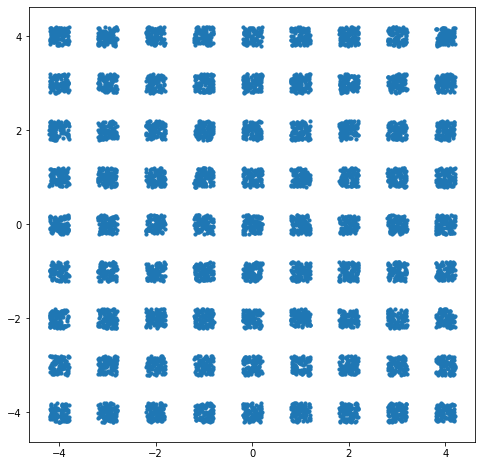

In [4]:
plt.figure(figsize=(8,8))
plt.scatter(x[:,0],x[:,1],s=10)

In [5]:
x = np.load('../data/x.npy').astype(np.float64) 
xx = np.load('../data/xx.npy').astype(np.float64) 
y = np.load('../data/y.npy')

print( np.min(xx[:,:1]) , np.max(xx[:,:1]) , np.mean(xx[:,:1]),np.std(xx[:,:1]))
print( np.min(xx[:,2:]) , np.max(xx[:,2:]) , np.mean(xx[:,2:]),np.std(xx[:,2:]) )

-4.199943434202072 4.199676160278704 -0.0019766245580556496 2.5860121765635813
-0.049106686730700615 0.08349903606898526 0.0002653424838935425 0.01064807110904549


(4860, 100) (4860,)


Text(0.5, 1.0, 'Test data')

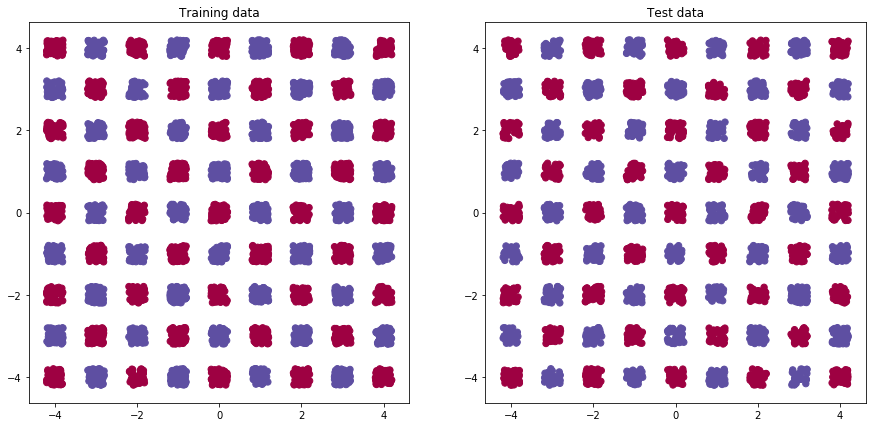

In [6]:
x_train,x_test,y_train,y_test = train_test_split(xx,y,test_size=0.4,random_state=0)

print(x_train.shape , y_train.shape)

plt.figure(figsize=(15,7))
plt.subplot(121)
plt.scatter(x_train[:,0],x_train[:,1],s=40,c=y_train,cmap=plt.cm.Spectral)
plt.title("Training data")
plt.subplot(122)
plt.scatter(x_test[:,0],x_test[:,1],s=40,c=y_test,cmap=plt.cm.Spectral)
plt.title("Test data")

## Define the network

In [7]:
net_width = 256
net_width_fc_layer = 64

#net_width = 64
#net_width_fc_layer = 16

class ResNet(nn.Module):
    def __init__(self, input_dim = 100 , num_classes = 2):
        super(ResNet, self).__init__()
        
        self.layer0 = nn.Sequential(
            nn.Linear(input_dim, net_width),
            nn.BatchNorm1d(net_width),
            nn.ReLU(),
            #nn.Dropout(0.2)
        )
        #nn.init.xavier_uniform(self.layer0[0].weight, 1)
        
        self.layer1 = nn.Sequential(
            nn.Linear(net_width, net_width),
            nn.BatchNorm1d(net_width),
            nn.ReLU(),
            #nn.Dropout(0.2)
        )
        #nn.init.xavier_uniform(self.layer1[0].weight, 1)
        
        self.layer2 = nn.Sequential(
            nn.Linear(net_width, net_width),
            nn.BatchNorm1d(net_width),
            nn.ReLU(),
            #nn.Dropout(0.2)
        )
        #nn.init.xavier_uniform(self.layer2[0].weight, 1)
        
        self.layer3 = nn.Sequential(
            nn.Linear(net_width, net_width),
            nn.BatchNorm1d(net_width),
            nn.ReLU(),
            #nn.Dropout(0.2)
        )
        #nn.init.xavier_uniform(self.layer3[0].weight, 1)
        
        self.layer4 = nn.Sequential(
            nn.Linear(net_width, net_width),
            nn.BatchNorm1d(net_width),
            nn.ReLU(),
            #nn.Dropout(0.2)
        )
        #nn.init.xavier_uniform(self.layer4[0].weight, 1)
        
        self.layer5 = nn.Sequential(
            nn.Linear(net_width, net_width),
            nn.BatchNorm1d(net_width),
            nn.ReLU(),
            #nn.Dropout(0.2)
        )
        #nn.init.xavier_uniform(self.layer5[0].weight, 1)
        
        self.layer6 = nn.Sequential(
            nn.Linear(net_width, net_width),
            nn.BatchNorm1d(net_width),
            nn.ReLU(),
            #nn.Dropout(0.2)
        )
            
        self.layer7 = nn.Sequential(
            nn.Linear(net_width, net_width_fc_layer),
            nn.BatchNorm1d(net_width_fc_layer)
        )
        #nn.init.xavier_uniform(self.layer6[0].weight, 1)
        
        self.layer8 = nn.Sequential(
            nn.Linear(net_width_fc_layer, num_classes)
        )
        #nn.init.xavier_uniform(self.layer7[0].weight, 1)
    
    def forward(self, x):
        outputs = self.layer0(x)
        
        outputs1 = self.layer1(outputs)
        outputs2 = self.layer2(outputs1 + outputs)
        
        outputs3 = self.layer3(outputs2)
        outputs4 = self.layer4(outputs3 + outputs2 )
        
        outputs5 = self.layer5(outputs4)
        outputs6 = self.layer6(outputs5 + outputs4 )
        
        outputs7 = self.layer7(outputs6)
        outputs8 = self.layer8(outputs7)

        return outputs8
    
    def predict(self,x):
        srcdata = torch.from_numpy(x).type(torch.FloatTensor).to(device)
        outputs = self.forward(srcdata)
        _, y_pred = torch.max(outputs.data, 1)
        return y_pred

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train = torch.from_numpy(x_train).type(torch.FloatTensor).to(device)
Y_train = torch.from_numpy(y_train).to(device)
X_test = torch.from_numpy(x_test).type(torch.FloatTensor).to(device)
Y_test = torch.from_numpy(y_test).to(device)

In [9]:
def Generate_data(x_data, y_data ,batch_size = 128) :
    
    train_data = TensorDataset(x_data, y_data )

    trainloader = torch.utils.data.DataLoader(train_data, 
                                              batch_size=batch_size
                                             )
    return trainloader

In [10]:
batch_size = 128
train_loader = Generate_data( X_train, Y_train, batch_size = batch_size )
test_loader  = Generate_data( X_test,  Y_test,  batch_size = batch_size )

In [11]:
print(X_train.shape)

torch.Size([4860, 100])


In [12]:
def eval_model(model_tst, loader_tst, dataset_name):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model_tst.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loader_tst:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model_tst(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            #print(total)

        print('Test Accuracy of the model on the ' + dataset_name + ' : {} %'.format(100 * correct / total))
        
    return 100 * correct / total

In [13]:
def edge(models , X , y , dim =100  ): 
    models.eval()
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    h = 0.04
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 201), np.linspace(y_min, y_max, 201))
    # Predict the function value for the whole gid
    t = np.c_[xx.ravel(), yy.ravel()]
    
    tt = np.zeros((t.shape[0],dim))
    tt[:,:2] = t
    
    X_test = torch.from_numpy(tt).float().to(device)
    outputs = models(X_test)
    _, y_pred = torch.max(outputs.data, 1)
    y_pred = y_pred.cpu().reshape(xx.shape)
    
    # Plot the contour and training examples
    
    plt.contourf(xx, yy, y_pred , cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.binary)

In [14]:
def visualize3D(vis_net, x, y, dir1, dir2, dir3, xlim = [-1,1], ylim = [-1,1], zlim = [-1,1]):
    
    # Normalize the two directions
    print('Take three orthogonal directions')
    dir1 = dir1/torch.norm(dir1, p = float('2'))
    dir2 = dir2/torch.norm(dir2, p = float('2'))
    dir3 = dir3/torch.norm(dir3, p = float('2'))
    
    # Check if the three directions are orthogonal to each other
    inner_product1 = torch.abs(torch.dot(dir1.view(-1), dir2.view(-1)))
    inner_product2 = torch.abs(torch.dot(dir1.view(-1), dir3.view(-1)))
    inner_product3 = torch.abs(torch.dot(dir2.view(-1), dir3.view(-1)))
    
    check_inner_product1 = (inner_product1<0.01).item()
    check_inner_product2 = (inner_product2<0.01).item()
    check_inner_product3 = (inner_product3<0.01).item()

    assert check_inner_product1, "The three directions are not orthogonal"
    assert check_inner_product2, "The three directions are not orthogonal"
    assert check_inner_product3, "The three directions are not orthogonal"
    
    # Generate the visualization and data grid
    #lenx, leny, lenz = 51, 51, 51
    xx, yy, zz = np.mgrid[xlim[0]:xlim[1]:30j, ylim[0]:ylim[1]:30j, zlim[0]:zlim[1]:30j]

    t = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]
    vis_grid = torch.from_numpy(t).float().to(device)
    dirs_mat = torch.cat([dir1.reshape(1, -1), dir2.reshape(1, -1), dir3.reshape(1, -1)]).to(device)
    x_grid = torch.mm(vis_grid, dirs_mat).to('cpu') + x
    
    print(x_grid[:,:100])
        
    grid_output = []
    grid_loader = torch.utils.data.DataLoader(TensorDataset(x_grid), batch_size=64, shuffle=False, num_workers=2)
    
    vis_net.eval()
    
    softmax1 = nn.Softmax()
    
    for grid_points in tqdm(grid_loader):
        
        grid_points = grid_points[0].to(device)
        grid_ys = vis_net(grid_points)    
        grid_ys = softmax1(grid_ys)
        grid_ys = grid_ys[:,y].detach().cpu().numpy()
        grid_output.append(grid_ys)
        
        #_, grid_ys = torch.max(grid_ys.data, 1)
        #grid_pred = (grid_ys.to('cpu') == y)
        #grid_output.append(grid_pred)
    
    y_pred0 = np.concatenate(grid_output)
    print([np.min(y_pred0),np.max(y_pred0)])
    #y_pred = y_pred0.reshape(xx.shape)
        
    # set the colors of each object
    #colors = np.empty(y_pred.shape, dtype=object)
    #colors[y_pred] = 'red'
    
    # and plot everything
    fig = go.Figure(data=go.Volume(
    x=xx.flatten(),
    y=yy.flatten(),
    z=zz.flatten(),
    value=y_pred0.flatten(),
    isomin=0,
    isomax=1,
    opacity=0.1, # needs to be small to see through all surfaces
    surface_count=17, # needs to be a large number for good volume rendering
    ))
    fig.show()
    
    return fig
    

# Training using stochastic gradient descent

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = NeuralNet().to(device)
model = ResNet(input_dim = dim).to(device)

def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [16]:
initial_lr = 0.003
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=initial_lr, momentum=0.9, weight_decay = 5e-4)  

In [17]:
num_epochs = 100

best_acc = 0
train = True
#train = False


if train :
    for epoch in range(num_epochs):
        
        model.train()
        
        if epoch > 0.75*num_epochs:
            lr = initial_lr/100
        elif epoch > 0.5*num_epochs:
            lr = initial_lr/10
        else:
            lr = initial_lr

        update_lr(optimizer, lr)

        for i, (inputs, targets) in enumerate(train_loader):

            inputs = inputs.to(device)
            targets = targets.to(device)
            
            outputs = model(inputs)
            #print(outputs.type())
            loss = criterion(outputs, targets)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if (epoch+1) % 10 == 0:
            print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
        
        if (epoch+1)% 10 == 0:

            #acc = accuracy_score(model.predict(x_test).cpu(),y_test )
            acc = eval_model(model,test_loader ,'src test data')

            if acc > best_acc:
                print('Saving model ' + '..')
                state = {
                    'net': model.state_dict(),
                    'acc': acc,
                }
                if not os.path.isdir('checkpoint'):
                    os.mkdir('checkpoint')
                torch.save(state, './checkpoint/Chessboard_'+ str(block)+ '_' + str(block)+'.pth')
                best_acc = acc
    print('best acc :' , best_acc)

Epoch [10/100], Loss: 0.3517
Test Accuracy of the model on the src test data : 88.64197530864197 %
Saving model ..
Epoch [20/100], Loss: 0.2864
Test Accuracy of the model on the src test data : 95.24691358024691 %
Saving model ..
Epoch [30/100], Loss: 0.1050
Test Accuracy of the model on the src test data : 97.46913580246914 %
Saving model ..
Epoch [40/100], Loss: 0.0667
Test Accuracy of the model on the src test data : 99.01234567901234 %
Saving model ..
Epoch [50/100], Loss: 0.0900
Test Accuracy of the model on the src test data : 99.16666666666667 %
Saving model ..
Epoch [60/100], Loss: 0.0151
Test Accuracy of the model on the src test data : 100.0 %
Saving model ..
Epoch [70/100], Loss: 0.0100
Test Accuracy of the model on the src test data : 100.0 %
Epoch [80/100], Loss: 0.0079
Test Accuracy of the model on the src test data : 100.0 %
Epoch [90/100], Loss: 0.0076
Test Accuracy of the model on the src test data : 100.0 %
Epoch [100/100], Loss: 0.0074
Test Accuracy of the model on t

In [18]:
checkpoint = torch.load('./checkpoint/Chessboard_'+ str(block)+ '_' + str(block)+'.pth')
model.load_state_dict(checkpoint['net'] )
print(checkpoint['acc'])

'''
print(accuracy_score(model.predict(x_train).cpu(),y_train ))
print(accuracy_score(model.predict(x_test).cpu(),y_test ))
'''

eval_model(model,train_loader ,'src train data')
eval_model(model,test_loader ,'src test data')


100.0
Test Accuracy of the model on the src train data : 100.0 %
Test Accuracy of the model on the src test data : 100.0 %


100.0

## Examine the results on the data manifold (in the middle)

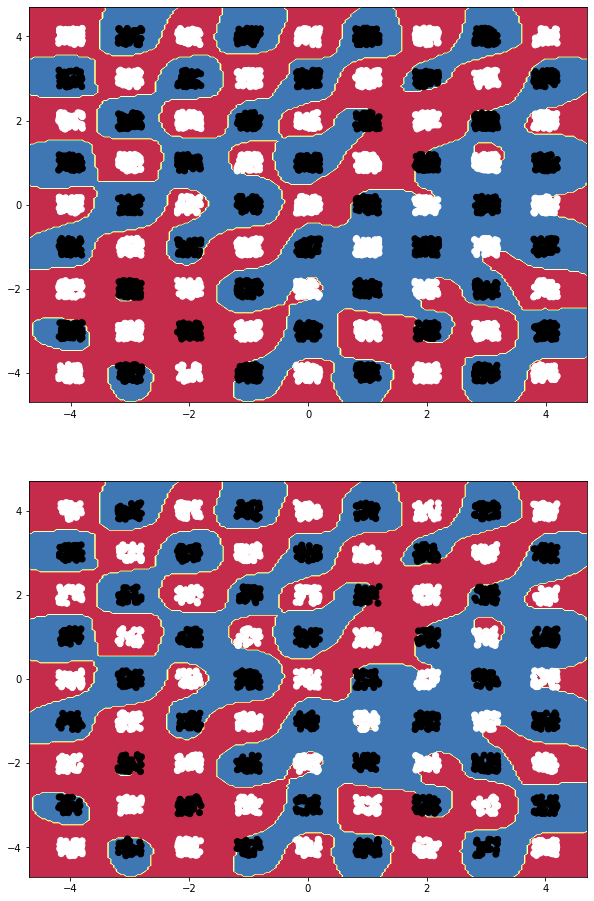

In [19]:
plt.figure(figsize=(10,16))
plt.subplot(211)
edge(model , x_train, y_train , dim = dim)
plt.subplot(212)
edge(model , x_test, y_test , dim = dim)
#plt.savefig('edge.pdf')

## Visualize a 3D decision boundary

In [ ]:
xlim = [-5, 5]
ylim = [-5, 5]
zlim = [-5, 5]

dir0 = torch.from_numpy(np.zeros(dim)).float()
dir1 = torch.from_numpy(np.zeros(dim)).float()
dir2 = torch.from_numpy(np.zeros(dim)).float()
dir0[0] = 1
dir1[1] = 1
dir2[2] = 1

fig = visualize3D(model, torch.from_numpy(np.zeros(dim)).float(), 0, dir0, dir1, dir2, xlim, ylim, zlim)